In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.utils.vis_utils import plot_model
%matplotlib inline


In [2]:
data_week = pd.read_csv('data_per_week.csv')
data_week.head()

quantity  price_per_item  freight_per_item  review  \
0         1           29.99              7.78     5.0   
1         0            0.00              0.00     0.0   
2         1           29.99              7.78     4.0   
3         0            0.00              0.00     0.0   
4         0            0.00              0.00     0.0   

                         product_id  order_price  order_freight  total_price  \
0  87285b34884572647811a353c7ac498a        29.99           7.78        37.77   
1  87285b34884572647811a353c7ac498a         0.00           0.00         0.00   
2  87285b34884572647811a353c7ac498a        29.99           7.78        37.77   
3  87285b34884572647811a353c7ac498a         0.00           0.00         0.00   
4  87285b34884572647811a353c7ac498a         0.00           0.00         0.00   

    ANO  MÊS           ...             12 MESES_ipca  Taxa (% a.a.)_selic  \
0  2017    8           ...                      2,46             8.872222   
1  2017    8           ...                      2,46             8.872222   
2  2017    8           ...                      2,46             8.872222   
3  2017    8           ...                      2,46             8.872222   
4  2017    9           ...                      2,54             8.165625   

   Fator diário_selic  Financeiro (R$)_selic  Operações_selic  Média_selic  \
0            1.000337           3.716054e+11       979.833333     8.872222   
1            1.000337           3.716054e+11       979.833333     8.872222   
2            1.000337           3.716054e+11       979.833333     8.872222   
3            1.000337           3.716054e+11       979.833333     8.872222   
4            1.000312           4.348451e+11       937.125000     8.165625   

  Mediana_selic  Moda_selic  Desvio padrão_selic  Índice de curtose_selic  
0      8.862222    8.872222             0.023889              1355.101667  
1      8.862222    8.872222             0.023889              1355.101667  
2      8.862222    8.872222             0.023889              1355.101667  
3      8.862222    8.872222             0.023889              1355.101667  
4      8.155625    8.165625             0.021875              1626.833750  

[5 rows x 32 columns]

In [3]:
data_month = pd.read_csv('data_per_month.csv')
data_month.head()

quantity  price_per_item  freight_per_item  review  \
0         2           29.99              7.78     4.5   
1         0            0.00              0.00     0.0   
2         2           29.99             11.41     3.5   
3         1          142.50             15.75     3.0   
4         1          142.50              9.19     1.0   

                         product_id  order_price  order_freight  total_price  \
0  87285b34884572647811a353c7ac498a        29.99           7.78        37.77   
1  87285b34884572647811a353c7ac498a         0.00           0.00         0.00   
2  87285b34884572647811a353c7ac498a        29.99          11.41        41.40   
3  595fac2a385ac33a80bd5114aec74eb8       142.50          15.75       158.25   
4  595fac2a385ac33a80bd5114aec74eb8       142.50           9.19       151.69   

    ANO  MÊS           ...             12 MESES_ipca  Taxa (% a.a.)_selic  \
0  2017    8           ...                      2,46             8.872222   
1  2017    9           ...                      2,54             8.165625   
2  2017   10           ...                      2,70             8.105882   
3  2017    8           ...                      2,46             8.872222   
4  2017    9           ...                      2,54             8.165625   

   Fator diário_selic  Financeiro (R$)_selic  Operações_selic  Média_selic  \
0            1.000337           3.716054e+11       979.833333     8.872222   
1            1.000312           4.348451e+11       937.125000     8.165625   
2            1.000309           4.300528e+11       915.823529     8.105294   
3            1.000337           3.716054e+11       979.833333     8.872222   
4            1.000312           4.348451e+11       937.125000     8.165625   

  Mediana_selic  Moda_selic  Desvio padrão_selic  Índice de curtose_selic  
0      8.862222    8.872222             0.023889              1355.101667  
1      8.155625    8.165625             0.021875              1626.833750  
2      8.095882    8.105882             0.030000              1161.462353  
3      8.862222    8.872222             0.023889              1355.101667  
4      8.155625    8.165625             0.021875              1626.833750  

[5 rows x 32 columns]

In [6]:
def get_last_values(columns=['price_per_item','freight_per_item','review'], prod=None):
    prod = prod.sort_values(['ANO','MÊS'])
    for col in columns:
        for index in prod.index.tolist():
            if prod.loc[index,col]==0 and index !=0:
                prod.loc[index,col] = prod.loc[index-1,col]
    return prod

In [7]:
# convert an array of values into a dataset matrix
def create_window_dataset(dataset, look_back=1):
    dataX = [[] for _ in dataset]
    dataY = [[] for _ in dataset]
    for i in range(look_back,len(dataset)):
        dataY[i].append(dataset[i][0])
        for j in range(look_back):
            dataX[i].append((dataset[i-(j+1)]))
    return np.asarray(dataX[look_back:]), np.asarray(dataY[look_back:])

In [8]:
def df_to_np(dataframe):
    # load the dataset
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(-1, 1))
    dataset = scaler.fit_transform(dataset)
    # split into train and test sets
    train_size = int(len(dataset) * 0.7)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return dataset,train, test


In [9]:
#prepara os dados por Produto

prod2_per_week = data_week.loc[data_week['product_id'] == '99a4788cb24856965c36a24e339b6058']
prod2_per_week = get_last_values(prod=prod2_per_week)
prod2_per_week = prod2_per_week.drop(['product_id','NÚMERO ÍNDICE_inpc','NO ANO_inpc','6 MESES_inpc', '12 MESES_inpc', 'NÚMERO ÍNDICE_ipca','NO ANO_ipca','6 MESES_ipca', '12 MESES_ipca', 'date'], axis=1)
prod2_per_week.head()

quantity  price_per_item  freight_per_item    review  order_price  \
5824         8            89.9         13.711429  3.571429   102.742857   
5825         5            89.9         15.034000  3.800000    89.900000   
5826         6            89.9         12.390000  3.500000   134.850000   
5827         5            89.9         12.130000  4.250000   112.375000   
5828         6            89.9         15.763333  4.500000    89.900000   

      order_freight  total_price   ANO  MÊS  MÊS_onpc  \
5824      16.044286   118.787143  2017    3      0.32   
5825      15.034000   104.934000  2017    3      0.32   
5826      18.530000   153.380000  2017    3      0.32   
5827      14.940000   127.315000  2017    3      0.32   
5828      15.763333   105.663333  2017    4      0.08   

               ...             3 MESES_ipca  Taxa (% a.a.)_selic  \
5824           ...                     0.96               8.7125   
5825           ...                     0.96               8.7125   
5826           ...                     0.96               8.7125   
5827           ...                     0.96               8.7125   
5828           ...                     0.72               8.8000   

      Fator diário_selic  Financeiro (R$)_selic  Operações_selic  Média_selic  \
5824            1.000331           4.034890e+11           940.25       8.7125   
5825            1.000331           4.034890e+11           940.25       8.7125   
5826            1.000331           4.034890e+11           940.25       8.7125   
5827            1.000331           4.034890e+11           940.25       8.7125   
5828            1.000335           3.924734e+11           938.80       8.7980   

      Mediana_selic  Moda_selic  Desvio padrão_selic  Índice de curtose_selic  
5824         8.7025      8.7125               0.0275                1924.1025  
5825         8.7025      8.7125               0.0275                1924.1025  
5826         8.7025      8.7125               0.0275                1924.1025  
5827         8.7025      8.7125               0.0275                1924.1025  
5828         8.7900      8.8000               0.0320                 999.1280  

[5 rows x 22 columns]

In [10]:
fullset, train, test = df_to_np(prod2_per_week)
fullset

array([[-0.3043478 ,  1.000001  , -0.5785022 , ...,  0.45742798,
        -0.6999999 ,  0.99999976],
       [-0.5652174 ,  1.000001  , -0.5073196 , ...,  0.45742798,
        -0.6999999 ,  0.99999976],
       [-0.47826087,  1.000001  , -0.6496232 , ...,  0.45742798,
        -0.6999999 ,  0.99999976],
       ...,
       [-0.82608694, -1.        , -0.5182992 , ..., -0.89219   ,
        -0.5666666 , -0.31732213],
       [-0.9130435 , -1.        , -0.06135631, ..., -0.89219   ,
        -0.5666666 , -0.31732213],
       [-0.47826087, -1.        , -0.42691064, ..., -0.89219   ,
        -0.5666666 , -0.31732213]], dtype=float32)

In [11]:
np.random.seed(7)
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_window_dataset(train, look_back)
testX, testY = create_window_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
#testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
trainX.shape

(49, 4, 22)

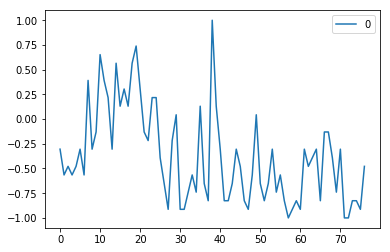

In [12]:
plotdf = pd.DataFrame(fullset[:,0])
plotdf.plot()

In [13]:
import pickle


#with open('prod2_fullset_test_train.pkl', 'wb') as f:
#    pickle.dump([fullset,train,test], f)

# Getting back the objects:
#with open('prod2_test_train.pkl') as f:  # Python 3: open(..., 'rb')
#    trainX,trainY,testX,testY = pickle.load(f)

In [24]:
#LSTM Autoencoder, take 1 :)
#if we take a brief look up, we can see TrainX shape.

from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

latent_dim = 3
input_dim = 22
timesteps = look_back

inputs = Input(shape=(timesteps, input_dim))
pre_encoded = LSTM(2*latent_dim, return_sequences=True)(inputs)
encoded = LSTM(latent_dim)(pre_encoded)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)
#entender Modelo
sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.compile(optimizer='rmsprop', loss='mean_squared_error')

sequence_autoencoder.fit(trainX, trainX, batch_size=10, epochs=1500, verbose=2)

Epoch 1/1500
 - 1s - loss: 0.3531
Epoch 2/1500
 - 0s - loss: 0.3492
Epoch 3/1500
 - 0s - loss: 0.3454
Epoch 4/1500
 - 0s - loss: 0.3409
Epoch 5/1500
 - 0s - loss: 0.3358
Epoch 6/1500
 - 0s - loss: 0.3297
Epoch 7/1500
 - 0s - loss: 0.3230
Epoch 8/1500
 - 0s - loss: 0.3156
Epoch 9/1500
 - 0s - loss: 0.3075
Epoch 10/1500
 - 0s - loss: 0.2988
Epoch 11/1500
 - 0s - loss: 0.2900
Epoch 12/1500
 - 0s - loss: 0.2812
Epoch 13/1500
 - 0s - loss: 0.2725
Epoch 14/1500
 - 0s - loss: 0.2642
Epoch 15/1500
 - 0s - loss: 0.2566
Epoch 16/1500
 - 0s - loss: 0.2496
Epoch 17/1500
 - 0s - loss: 0.2432
Epoch 18/1500
 - 0s - loss: 0.2374
Epoch 19/1500
 - 0s - loss: 0.2322
Epoch 20/1500
 - 0s - loss: 0.2274
Epoch 21/1500
 - 0s - loss: 0.2231
Epoch 22/1500
 - 0s - loss: 0.2191
Epoch 23/1500
 - 0s - loss: 0.2153
Epoch 24/1500
 - 0s - loss: 0.2117
Epoch 25/1500
 - 0s - loss: 0.2081
Epoch 26/1500
 - 0s - loss: 0.2050
Epoch 27/1500
 - 0s - loss: 0.2018
Epoch 28/1500
 - 0s - loss: 0.1989
Epoch 29/1500
 - 0s - loss: 0

Epoch 232/1500
 - 0s - loss: 0.0728
Epoch 233/1500
 - 0s - loss: 0.0729
Epoch 234/1500
 - 0s - loss: 0.0729
Epoch 235/1500
 - 0s - loss: 0.0727
Epoch 236/1500
 - 0s - loss: 0.0728
Epoch 237/1500
 - 0s - loss: 0.0726
Epoch 238/1500
 - 0s - loss: 0.0723
Epoch 239/1500
 - 0s - loss: 0.0725
Epoch 240/1500
 - 0s - loss: 0.0724
Epoch 241/1500
 - 0s - loss: 0.0720
Epoch 242/1500
 - 0s - loss: 0.0726
Epoch 243/1500
 - 0s - loss: 0.0721
Epoch 244/1500
 - 0s - loss: 0.0718
Epoch 245/1500
 - 0s - loss: 0.0718
Epoch 246/1500
 - 0s - loss: 0.0718
Epoch 247/1500
 - 0s - loss: 0.0720
Epoch 248/1500
 - 0s - loss: 0.0716
Epoch 249/1500
 - 0s - loss: 0.0718
Epoch 250/1500
 - 0s - loss: 0.0716
Epoch 251/1500
 - 0s - loss: 0.0713
Epoch 252/1500
 - 0s - loss: 0.0713
Epoch 253/1500
 - 0s - loss: 0.0712
Epoch 254/1500
 - 0s - loss: 0.0711
Epoch 255/1500
 - 0s - loss: 0.0715
Epoch 256/1500
 - 0s - loss: 0.0711
Epoch 257/1500
 - 0s - loss: 0.0710
Epoch 258/1500
 - 0s - loss: 0.0711
Epoch 259/1500
 - 0s - loss:

Epoch 460/1500
 - 0s - loss: 0.0623
Epoch 461/1500
 - 0s - loss: 0.0622
Epoch 462/1500
 - 0s - loss: 0.0624
Epoch 463/1500
 - 0s - loss: 0.0621
Epoch 464/1500
 - 0s - loss: 0.0625
Epoch 465/1500
 - 0s - loss: 0.0622
Epoch 466/1500
 - 0s - loss: 0.0624
Epoch 467/1500
 - 0s - loss: 0.0620
Epoch 468/1500
 - 0s - loss: 0.0620
Epoch 469/1500
 - 0s - loss: 0.0625
Epoch 470/1500
 - 0s - loss: 0.0624
Epoch 471/1500
 - 0s - loss: 0.0621
Epoch 472/1500
 - 0s - loss: 0.0620
Epoch 473/1500
 - 0s - loss: 0.0618
Epoch 474/1500
 - 0s - loss: 0.0626
Epoch 475/1500
 - 0s - loss: 0.0619
Epoch 476/1500
 - 0s - loss: 0.0618
Epoch 477/1500
 - 0s - loss: 0.0620
Epoch 478/1500
 - 0s - loss: 0.0618
Epoch 479/1500
 - 0s - loss: 0.0622
Epoch 480/1500
 - 0s - loss: 0.0620
Epoch 481/1500
 - 0s - loss: 0.0618
Epoch 482/1500
 - 0s - loss: 0.0620
Epoch 483/1500
 - 0s - loss: 0.0621
Epoch 484/1500
 - 0s - loss: 0.0617
Epoch 485/1500
 - 0s - loss: 0.0621
Epoch 486/1500
 - 0s - loss: 0.0615
Epoch 487/1500
 - 0s - loss:

Epoch 688/1500
 - 0s - loss: 0.0586
Epoch 689/1500
 - 0s - loss: 0.0582
Epoch 690/1500
 - 0s - loss: 0.0584
Epoch 691/1500
 - 0s - loss: 0.0585
Epoch 692/1500
 - 0s - loss: 0.0584
Epoch 693/1500
 - 0s - loss: 0.0583
Epoch 694/1500
 - 0s - loss: 0.0582
Epoch 695/1500
 - 0s - loss: 0.0583
Epoch 696/1500
 - 0s - loss: 0.0585
Epoch 697/1500
 - 0s - loss: 0.0582
Epoch 698/1500
 - 0s - loss: 0.0582
Epoch 699/1500
 - 0s - loss: 0.0583
Epoch 700/1500
 - 0s - loss: 0.0581
Epoch 701/1500
 - 0s - loss: 0.0581
Epoch 702/1500
 - 0s - loss: 0.0582
Epoch 703/1500
 - 0s - loss: 0.0586
Epoch 704/1500
 - 0s - loss: 0.0579
Epoch 705/1500
 - 0s - loss: 0.0583
Epoch 706/1500
 - 0s - loss: 0.0580
Epoch 707/1500
 - 0s - loss: 0.0580
Epoch 708/1500
 - 0s - loss: 0.0580
Epoch 709/1500
 - 0s - loss: 0.0582
Epoch 710/1500
 - 0s - loss: 0.0583
Epoch 711/1500
 - 0s - loss: 0.0580
Epoch 712/1500
 - 0s - loss: 0.0582
Epoch 713/1500
 - 0s - loss: 0.0583
Epoch 714/1500
 - 0s - loss: 0.0580
Epoch 715/1500
 - 0s - loss:

Epoch 916/1500
 - 0s - loss: 0.0532
Epoch 917/1500
 - 0s - loss: 0.0535
Epoch 918/1500
 - 0s - loss: 0.0533
Epoch 919/1500
 - 0s - loss: 0.0533
Epoch 920/1500
 - 0s - loss: 0.0538
Epoch 921/1500
 - 0s - loss: 0.0532
Epoch 922/1500
 - 0s - loss: 0.0531
Epoch 923/1500
 - 0s - loss: 0.0536
Epoch 924/1500
 - 0s - loss: 0.0531
Epoch 925/1500
 - 0s - loss: 0.0532
Epoch 926/1500
 - 0s - loss: 0.0536
Epoch 927/1500
 - 0s - loss: 0.0530
Epoch 928/1500
 - 0s - loss: 0.0532
Epoch 929/1500
 - 0s - loss: 0.0530
Epoch 930/1500
 - 0s - loss: 0.0533
Epoch 931/1500
 - 0s - loss: 0.0532
Epoch 932/1500
 - 0s - loss: 0.0531
Epoch 933/1500
 - 0s - loss: 0.0530
Epoch 934/1500
 - 0s - loss: 0.0531
Epoch 935/1500
 - 0s - loss: 0.0529
Epoch 936/1500
 - 0s - loss: 0.0530
Epoch 937/1500
 - 0s - loss: 0.0533
Epoch 938/1500
 - 0s - loss: 0.0532
Epoch 939/1500
 - 0s - loss: 0.0532
Epoch 940/1500
 - 0s - loss: 0.0528
Epoch 941/1500
 - 0s - loss: 0.0530
Epoch 942/1500
 - 0s - loss: 0.0529
Epoch 943/1500
 - 0s - loss:

Epoch 1140/1500
 - 0s - loss: 0.0508
Epoch 1141/1500
 - 0s - loss: 0.0507
Epoch 1142/1500
 - 0s - loss: 0.0506
Epoch 1143/1500
 - 0s - loss: 0.0508
Epoch 1144/1500
 - 0s - loss: 0.0509
Epoch 1145/1500
 - 0s - loss: 0.0508
Epoch 1146/1500
 - 0s - loss: 0.0506
Epoch 1147/1500
 - 0s - loss: 0.0508
Epoch 1148/1500
 - 0s - loss: 0.0509
Epoch 1149/1500
 - 0s - loss: 0.0505
Epoch 1150/1500
 - 0s - loss: 0.0509
Epoch 1151/1500
 - 0s - loss: 0.0507
Epoch 1152/1500
 - 0s - loss: 0.0506
Epoch 1153/1500
 - 0s - loss: 0.0508
Epoch 1154/1500
 - 0s - loss: 0.0508
Epoch 1155/1500
 - 0s - loss: 0.0508
Epoch 1156/1500
 - 0s - loss: 0.0505
Epoch 1157/1500
 - 0s - loss: 0.0508
Epoch 1158/1500
 - 0s - loss: 0.0505
Epoch 1159/1500
 - 0s - loss: 0.0505
Epoch 1160/1500
 - 0s - loss: 0.0505
Epoch 1161/1500
 - 0s - loss: 0.0505
Epoch 1162/1500
 - 0s - loss: 0.0509
Epoch 1163/1500
 - 0s - loss: 0.0504
Epoch 1164/1500
 - 0s - loss: 0.0507
Epoch 1165/1500
 - 0s - loss: 0.0506
Epoch 1166/1500
 - 0s - loss: 0.0504
E

 - 0s - loss: 0.0491
Epoch 1362/1500
 - 0s - loss: 0.0490
Epoch 1363/1500
 - 0s - loss: 0.0489
Epoch 1364/1500
 - 0s - loss: 0.0494
Epoch 1365/1500
 - 0s - loss: 0.0491
Epoch 1366/1500
 - 0s - loss: 0.0491
Epoch 1367/1500
 - 0s - loss: 0.0493
Epoch 1368/1500
 - 0s - loss: 0.0494
Epoch 1369/1500
 - 0s - loss: 0.0489
Epoch 1370/1500
 - 0s - loss: 0.0492
Epoch 1371/1500
 - 0s - loss: 0.0491
Epoch 1372/1500
 - 0s - loss: 0.0492
Epoch 1373/1500
 - 0s - loss: 0.0489
Epoch 1374/1500
 - 0s - loss: 0.0489
Epoch 1375/1500
 - 0s - loss: 0.0489
Epoch 1376/1500
 - 0s - loss: 0.0496
Epoch 1377/1500
 - 0s - loss: 0.0490
Epoch 1378/1500
 - 0s - loss: 0.0490
Epoch 1379/1500
 - 0s - loss: 0.0490
Epoch 1380/1500
 - 0s - loss: 0.0492
Epoch 1381/1500
 - 0s - loss: 0.0490
Epoch 1382/1500
 - 0s - loss: 0.0489
Epoch 1383/1500
 - 0s - loss: 0.0490
Epoch 1384/1500
 - 0s - loss: 0.0488
Epoch 1385/1500
 - 0s - loss: 0.0488
Epoch 1386/1500
 - 0s - loss: 0.0496
Epoch 1387/1500
 - 0s - loss: 0.0488
Epoch 1388/1500
 

In [31]:
plot_model(sequence_autoencoder, to_file='Autoencoder_model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:
trainX_autoencoder = [_ for i in train]
testX_autoencoder = [_ for i in test]
filler = np.zeros(latent_dim)
encoded_train = encoder.predict(trainX)
encoded_test = encoder.predict(testX)
for i in range(0,look_back):
    trainX_autoencoder[i] = np.append(train[i],filler)
    testX_autoencoder[i] = np.append(test[i],filler)
for i in range(look_back,len(train)):
    aux_encoded_train = encoded_train[i-look_back]
    trainX_autoencoder[i] = np.append(train[i],aux_encoded)
for i in range(look_back,len(test)):
    aux_encoded_test = encoded_test[i-look_back]
    testX_autoencoder[i] = np.append(test[i],aux_encoded)

In [25]:
#MODDED: only saving encoded values
trainX_autoencoder = [_ for i in train]
testX_autoencoder = [_ for i in test]
filler = np.zeros(latent_dim)
encoded_train = encoder.predict(trainX)
encoded_test = encoder.predict(testX)
for i in range(0,look_back):
    trainX_autoencoder[i] = np.append(train[i][0],filler)
    testX_autoencoder[i] = np.append(test[i][0],filler)
for i in range(look_back,len(train)):
    aux_encoded_train = encoded_train[i-look_back]
    trainX_autoencoder[i] = np.append(train[i][0],aux_encoded_train)
for i in range(look_back,len(test)):
    aux_encoded_test = encoded_test[i-look_back]
    testX_autoencoder[i] = np.append(test[i][0],aux_encoded_test)

In [26]:
with open('prod2_test_train_autoencoder_window4_size3.pkl', 'wb') as f:
    pickle.dump([np.asarray(trainX_autoencoder),np.asarray(testX_autoencoder)], f)

In [19]:
np.asarray(train_autoencoder).shape

(53, 42)

In [20]:
test.shape

(24, 22)